In [39]:
import pandas as pd
import torch
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig, AutoModelForCausalLM
from transformers import PreTrainedTokenizerFast
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors

from src.utils import all_rools_valid, smiles_valid

from typing import List, Dict
import re

In [4]:
model_name_or_id = "OpenDFM/ChemDFM-v1.5-8B"
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name_or_id)
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_id,
    torch_dtype=torch.float16,
    device_map="balanced",
    max_memory={0: '10GB', 1: '10GB'}
)

Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


In [5]:
generation_config = GenerationConfig(
    do_sample=True,
    top_k=20,
    top_p=0.9,
    temperature=0.5,
    max_new_tokens=1024,
    repetition_penalty=1.05,
    eos_token_id=tokenizer.eos_token_id
)

In [6]:
df = pd.read_csv('./data/Neftekod_initial_data.csv')

In [7]:
df_valid = df[df['Smiles'].apply(all_rools_valid)]

In [8]:
PROMPT = """
Create {n} UNIQUE new antioxidant supplement molecules as SMILES strings that meet ALL criteria:
1. Class: Aromatic amines OR phenols 
2. Structure:
   - Only atoms: C, H, O, N, P, S
   - Molecular weight ≤ 1000 g/mol
   - Neutral molecules (no charges/radicals)
   - logP > 1 (hexane-soluble)
3. Target property: Maximize oxidation induction time (PDSC) ≥ 60 mins at:
   - 0.1 mol/kg for phenols
   - 0.05 mol/kg for amines
4. Synthetic feasibility: Prioritize structures with:
   - Available commercial building blocks
   - ≤ 5 synthetic steps (retrosynthesis)
   - No unstable functional groups

Additional guidance:
- Include multiple electron-donating groups (e.g., -NH2, -OH) 
- Avoid steric hindrance near active sites
- Consider conjugated systems for radical stabilization
- Prefer compact aromatic cores with branched substituents

Example SMILES:
{examples}

Output format JSON - only: [{"SMILES": "C...", "class": "amine/phenol", "Predicted_PDSC": float}]
don't forget quotation marks
"""

In [19]:
q_df = pd.read_csv('./data/quantitive_neftekod25_data.csv').drop_duplicates('SMILES', keep='first')

In [22]:
def get_answer(prompt: str, n_molecules: int, example_smiles: List[str]) -> Dict[str, str]:

    formated_prompt = prompt.replace('{n}', str(n_molecules)).replace('{examples}', '\n'.join(example_smiles))
    
    input_text = f"[Round 0]\nHuman: {formated_prompt}\nAssistant:"
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")


    outputs = model.generate(**inputs, generation_config=generation_config)
    generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0][len(input_text):]

    print(generated_text)
    
    result_list = generated_text[generated_text.find('['):generated_text.rfind(']')+1]
    
    return eval(result_list)

In [23]:
new_molecules = get_answer(
    prompt=PROMPT,
    n_molecules=10,
    example_smiles=q_df.sort_values(by='PDSC', ascending=False).head(1)['SMILES'].tolist(),
)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 Here are 10 unique antioxidant supplement molecules that meet all the given criteria:

```json
[
    {
        "SMILES": "Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1",
        "class": "phenol",
        "Predicted PDSC": 63.8
    },
    {
        "SMILES": "Cc1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1",
        "class": "amine",
        "Predicted PDSC": 58.9
    },
    {
        "SMiles": "Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N",
        "class": "phenol",
        "Predicted PDSC": 62.1
    },
    {
        "SMiles": "CSc1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1",
        "class": "amine",
        "Predicted PDSC": 55.7
    },
    {
        "SMiles": "CSc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N",
        "class": "phenol",
        "Predicted PDSC": 59.5
    },
    {
        "SMiles": "CNC(=O)c1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1",
        "class": "amine",
        "Predicted PDSC": 53.2
    },
    {
        "SMiles": "CNC(=O)c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N",
        "class": "phenol",
        "Predicted PDSC": 57.8
    },
    {
       

In [53]:
new_molecules_df = pd.DataFrame(new_molecules)

In [54]:
print('new unique molecules:', new_molecules_df.SMiles.nunique())

new unique molecules: 8


In [55]:
new_molecules_df = new_molecules_df.drop_duplicates('SMiles')

In [56]:
print('repeat original:', new_molecules_df['SMiles'].str.upper().isin(df_valid['Smiles']).astype(int).sum())

repeat original: 0


In [57]:
print('valud molecules', new_molecules_df['SMiles'].apply(all_rools_valid).astype(int).sum())

valud molecules 8


In [58]:
new_valid_molecules_df = new_molecules_df[new_molecules_df['SMiles'].apply(all_rools_valid)]

In [59]:
new_valid_molecules_df

,SMILES,class,Predicted PDSC,SMiles
2,NaN,phenol,62.1,Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N
3,NaN,amine,55.7,CSc1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1
4,NaN,phenol,59.5,CSc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N
5,NaN,amine,53.2,CNC(=O)c1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1
6,NaN,phenol,57.8,CNC(=O)c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N
7,NaN,amine,50.3,CCOC(=O)c1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1
8,NaN,phenol,54.6,CCOC(=O)c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N
9,NaN,amine/phenol,51.2,CCOC(=O)c1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1O


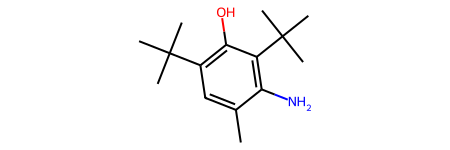

Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N


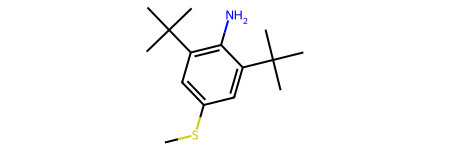

CSc1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1


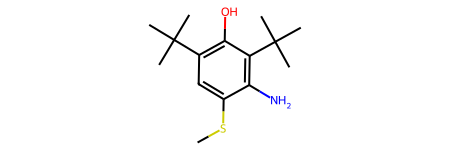

CSc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N


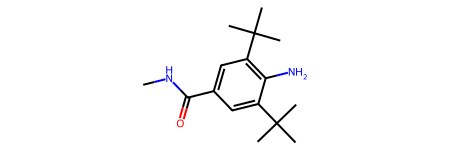

CNC(=O)c1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1


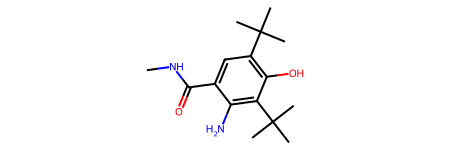

CNC(=O)c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N


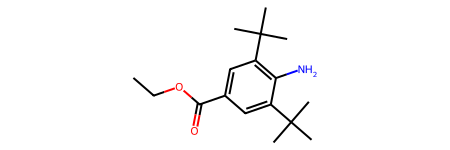

CCOC(=O)c1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1


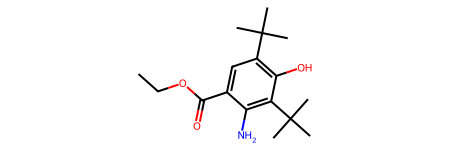

CCOC(=O)c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N


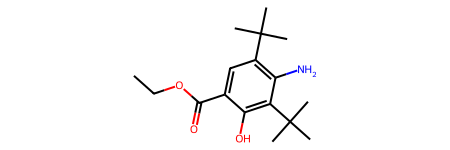

CCOC(=O)c1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1O


In [60]:
for i in range(len(new_valid_molecules_df)):
    display(Chem.MolFromSmiles(new_valid_molecules_df.SMiles.iloc[i]))
    print(new_valid_molecules_df.SMiles.iloc[i])

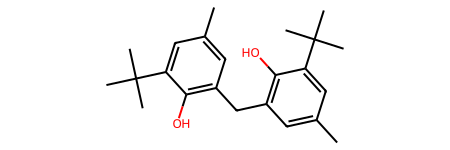

CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C(C)(C)C)O


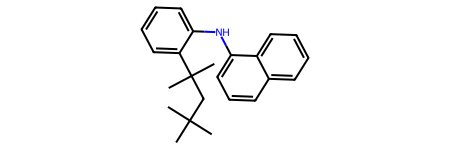

CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32


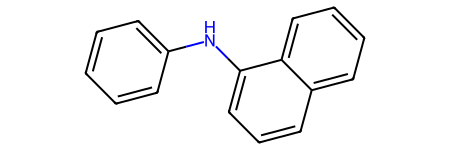

C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32


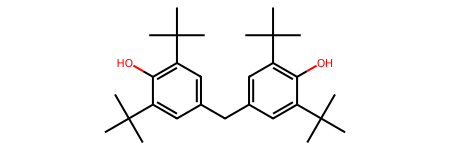

CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C2)C(C)(C)C)O)C(C)(C)C


In [61]:
base_examples = q_df.sort_values(by='PDSC', ascending=False).head(4)

for i in range(len(base_examples)):
    display(Chem.MolFromSmiles(base_examples.SMILES.iloc[i]))
    print(base_examples.SMILES.iloc[i])

In [67]:
for descriptor_name, descriptor_func in Descriptors.descList:
    if descriptor_name in {'EState_VSA4', 'NumHDonors', 'NHOHCount', 'VSA_EState3'}:
        new_valid_molecules_df.loc[:, descriptor_name] = new_valid_molecules_df['SMiles'].apply(lambda smiles: descriptor_func(Chem.MolFromSmiles(smiles)))

new_valid_molecules_df

,SMILES,class,Predicted PDSC,SMiles,EState_VSA4,VSA_EState3,NHOHCount,NumHDonors
2,NaN,phenol,62.1,Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N,16.690354,10.485324,3,2
3,NaN,amine,55.7,CSc1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1,5.687386,0.000000,2,1
4,NaN,phenol,59.5,CSc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N,16.022386,10.571586,3,2
5,NaN,amine,53.2,CNC(=O)c1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1,16.814289,2.678297,3,2
6,NaN,phenol,57.8,CNC(=O)c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N,5.563451,13.206418,4,3
7,NaN,amine,50.3,CCOC(=O)c1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1,16.814289,0.000000,2,1
8,NaN,phenol,54.6,CCOC(=O)c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1N,0.000000,10.644891,3,2
9,NaN,amine/phenol,51.2,CCOC(=O)c1cc(C(C)(C)C)c(N)c(C(C)(C)C)c1O,5.563451,10.511646,3,2


In [68]:
for descriptor_name, descriptor_func in Descriptors.descList:
    if descriptor_name in {'EState_VSA4', 'NumHDonors', 'NHOHCount', 'VSA_EState3'}:
        base_examples.loc[:, descriptor_name] = base_examples['SMILES'].apply(lambda smiles: descriptor_func(Chem.MolFromSmiles(smiles)))

base_examples

,SMILES,C,PDSC,EState_VSA4,VSA_EState3,NHOHCount,NumHDonors
37,CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C...,0.008837,31.79,33.380709,21.635836,2,2
8,CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32,0.009077,10.93,12.108208,6.228102,1,1
18,C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32,0.013722,10.86,11.374773,5.953643,1,1
43,CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C...,0.007086,10.86,28.674628,22.110983,2,2


In [70]:
new_valid_molecules_df['SMiles'].to_csv('submit.csv', encoding='UTF-8', index=False)

In [71]:
import os
import zipfile
with zipfile.ZipFile('submission.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('submit.csv', os.path.basename('submit.csv'))
    zipf.write('3_chem_llms_inference.ipynb', os.path.basename('3_chem_llms_inference.ipynb'))